In [1]:
%load_ext autoreload
%autoreload 2

expr_path = '/home/sbanerjee/Documents/work/sparse-regression/gradvi-experiments/dsc/functions'

import numpy as np
import sys
sys.path.append(expr_path)
import simulate

import matplotlib
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)
from mpl_toolkits.axes_grid1 import make_axes_locatable

10
[50 80]
cond 1 :0
cond 3 0:1
cond 2 1:
PVE: 0.6, Standard deviation: 9.147008871946998


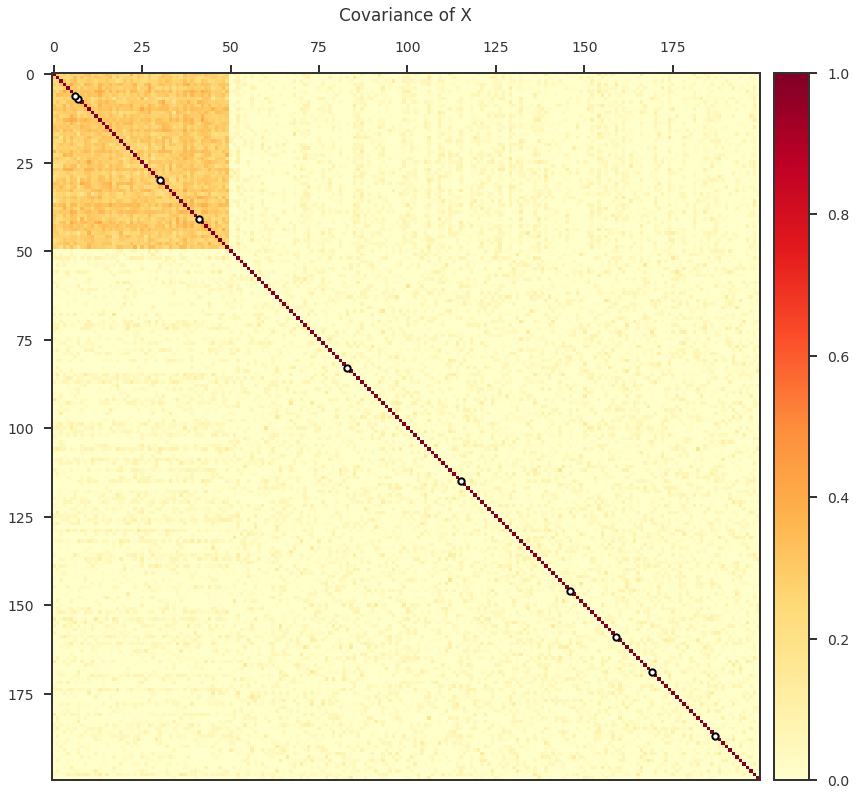

In [19]:
rholist = [0.3, 0.0, 0.]
#rholist = [0.3]
ntrain  = 5000
ntest   = 500
npred   = 200
cmin    = 10
pcausal = 10
pve = 0.6

cmin    = min(cmin, int(npred / (len(rholist))))
print (cmin)
ntot    = ntrain + ntest
iidx    = np.random.normal(0, 1.0, size = ntot * npred).reshape(ntot, npred)
comR    = [np.random.normal(0, 1.0, size = ntot).reshape(ntot, 1) for i in range(len(rholist))]
csplit  = cmin * np.sort(np.random.choice(int(npred / cmin) - 1, len(rholist) - 1, replace = False) + 1)
print(csplit)
allx    = np.zeros_like(iidx)
if len(rholist) > 1:
    for i, rho in enumerate(rholist):
        if i == 0:
            allx[:, :csplit[i]] = comR[i] * np.sqrt(rho) + iidx[:, :csplit[i]] * np.sqrt(1 - rho)
            print ("cond 1", f":{i}")
        elif i == len(rholist) - 1:
            allx[:, csplit[i-1]:] = comR[i] * np.sqrt(rho) + iidx[:, csplit[i-1]:] * np.sqrt(1 - rho)
            print ("cond 2", f"{i-1}:")
        elif i > 0 and i < len(rholist) - 1:
            allx[:, csplit[i-1]:csplit[i]] = comR[i] * np.sqrt(rho) + iidx[:, csplit[i-1]:csplit[i]] * np.sqrt(1 - rho)
            print ("cond 3", f"{i-1}:{i}")
elif len(rholist) == 1:
    rho   = rholist[0]
    allx  = comR[0] * np.sqrt(rho) + iidx * np.sqrt(1 - rho)

xtrain = allx[:ntrain, :]
xtest  = allx[ntrain:, :]
xtrain = simulate.center_and_scale(xtrain)
xtest  = simulate.center_and_scale(xtest)

bidx = np.random.choice(npred, pcausal, replace = False)
btrue = simulate.sample_coefs(npred, bidx, method = 'gamma', bfix = None)

se = simulate.get_sd_from_pve(xtrain, btrue, pve)
print (f"PVE: {pve}, Standard deviation: {se}")

ytrain = np.dot(xtrain, btrue) + se * np.random.normal(size = xtrain.shape[0])
ytest  = np.dot(xtest, btrue)  + se * np.random.normal(size = xtest.shape[0])

covx = np.cov(xtest.T, bias = True)

fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(111)

cmap1 = matplotlib.cm.get_cmap("YlOrRd").copy()
cmap1.set_bad("w")

norm1 = matplotlib.colors.TwoSlopeNorm(vmin=0., vcenter=0.5, vmax=1.)
im1 = ax1.imshow(covx.T, cmap = cmap1, norm = norm1, interpolation='nearest', origin = 'upper')
# im1 = ax1.matshow(covx, cmap = cmap1, norm = norm1)
ax1.tick_params(bottom = False, top = True, left = True, right = False,
                labelbottom = False, labeltop = True, labelleft = True, labelright = False)

ax1.scatter(bidx, bidx, s = 40, edgecolor = 'black', facecolor = 'white', lw = 2)


divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im1, cax=cax, fraction = 0.1)
ax1.set_title("Covariance of X", pad = 20)
plt.tight_layout()
plt.show()

In [6]:
blockidx = 40

covx[blockidx:, blockidx:]

array([[ 1.        ,  0.06731278, -0.02201386, ..., -0.00141963,
        -0.08724146,  0.06658435],
       [ 0.06731278,  1.        , -0.02083023, ..., -0.02460361,
         0.03340633,  0.03447685],
       [-0.02201386, -0.02083023,  1.        , ...,  0.11466635,
        -0.09187536, -0.04412919],
       ...,
       [-0.00141963, -0.02460361,  0.11466635, ...,  1.        ,
        -0.00252692,  0.02439211],
       [-0.08724146,  0.03340633, -0.09187536, ..., -0.00252692,
         1.        ,  0.05341452],
       [ 0.06658435,  0.03447685, -0.04412919, ...,  0.02439211,
         0.05341452,  1.        ]])

In [7]:
np.mean(covx[:blockidx, blockidx:])

-0.0021443469554426192

In [8]:
np.mean(covx[blockidx:, blockidx:])

0.015207284754653128

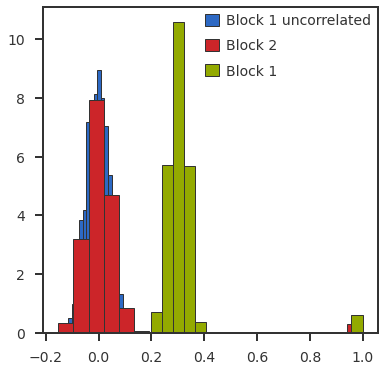

In [16]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.hist(covx[:blockidx, blockidx:].reshape(-1,), label = 'Block 1 uncorrelated', density = True)
ax1.hist(covx[blockidx:, blockidx:].reshape(-1,), label = 'Block 2', density = True)
ax1.hist(covx[:blockidx, :blockidx].reshape(-1,), label = 'Block 1', density = True)
ax1.legend()
plt.show()

In [14]:
covx.reshape(-1,)

array([1.        , 0.35525322, 0.32535405, ..., 0.02439211, 0.05341452,
       1.        ])

In [59]:
covx[300:, :300].T

array([[ 0.03562245, -0.02976953,  0.04554892, ...,  0.04833926,
         0.00946917,  0.02717463],
       [-0.11494371, -0.01310445,  0.05386286, ...,  0.07731964,
         0.05943189,  0.02825074],
       [ 0.01361927, -0.04282116,  0.04056372, ...,  0.05850911,
         0.00237909, -0.01691913],
       ...,
       [-0.04873225,  0.02339782,  0.0397301 , ...,  0.13821589,
        -0.02901586,  0.00139694],
       [-0.06219205,  0.04571623,  0.125872  , ...,  0.07323027,
         0.01917201,  0.04053482],
       [ 0.00884704, -0.0056334 ,  0.00483239, ...,  0.05913723,
         0.00028917,  0.0018984 ]])

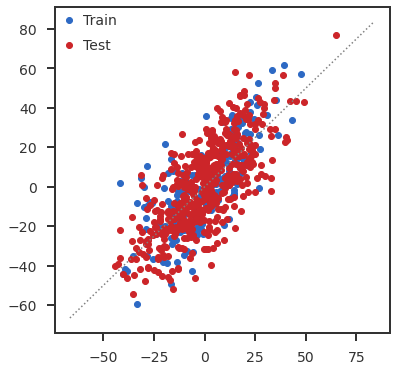

In [30]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(xtrain, btrue), ytrain, label = "Train")
ax1.scatter(np.dot(xtest, btrue), ytest, label = "Test")
ax1.legend()
mpl_utils.plot_diag(ax1)
plt.show()

In [8]:
btrue[np.where(btrue != 0)]

array([-3.35167796,  3.29215795, -3.44079519,  4.25876381,  4.1158741 ,
       -3.62668015, -4.76384334,  4.04680547, -3.83372738,  5.32214732])

In [9]:
np.sort(bidx)

array([233, 235, 275, 384, 440, 523, 529, 536, 959, 997])